In [115]:
#########################
###   GENERAL SETUP   ###
#########################

# REDIRECT IMPORTS
import sys
sys.path.append("../")
data_dir = "../data"

# IMPORTS
import os
from utils.load_utils import import_brava_data, get_exp_meta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, detrend
from scipy.ndimage import uniform_filter1d
from findiff import FinDiff
import utils.plot_utils as plot

# EXPERIMENT
exp_code = "b1380"
sampling_freq = 100
datapath = data_dir + "/"+exp_code+".txt"
picklepath = data_dir + "/" + exp_code + "_" + str(sampling_freq) +"hz.pickle"

### Experiment parameters

In [79]:
###   SLOW SERPENTINITE   ###
mov_mean_window = 10  # params
event_thresh_derivval = 2.5
event_thresh_derivdist = 100
event_halfwidth = 100

In [98]:
###   FAST SERPENTINITE   ###
mov_mean_window = 100  # params
event_thresh_derivval = 0.5
event_thresh_derivdist = 500
event_halfwidth = 250

In [53]:
###   MIN-U-SIL   ###
mov_mean_window = 5 # params
event_thresh_derivval = 0.5
event_thresh_derivdist = 50
event_halfwidth = 20

### Pick events

Importing BRAVA data...
...reading data from file...
...resampling... resampled...
... data imported


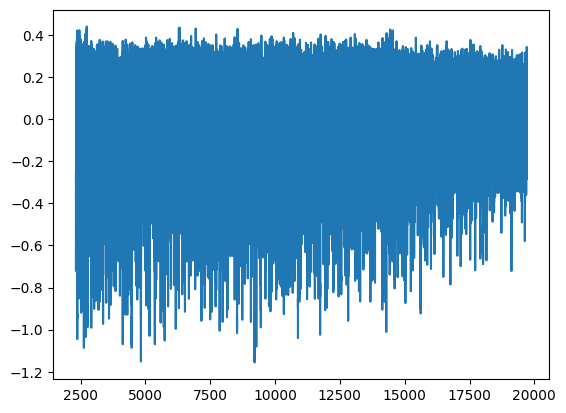

In [104]:
# IMPORT DATA
exp_meta = get_exp_meta(exp_code)
args = dict((k, exp_meta[k]) for k in ["t_start", "t_end", "ROIs"] if k in exp_meta)
data = import_brava_data(datapath, picklepath, downsample_factor=(1000 / sampling_freq), **args)
# plt.plot(data["TIME"], data["SHEAR STRESS"])
data["SHEAR DETRENDED"] = detrend(data["SHEAR STRESS"], bp=np.arange(0, len(data), 400*sampling_freq))
plt.plot(data["TIME"], data["SHEAR DETRENDED"])

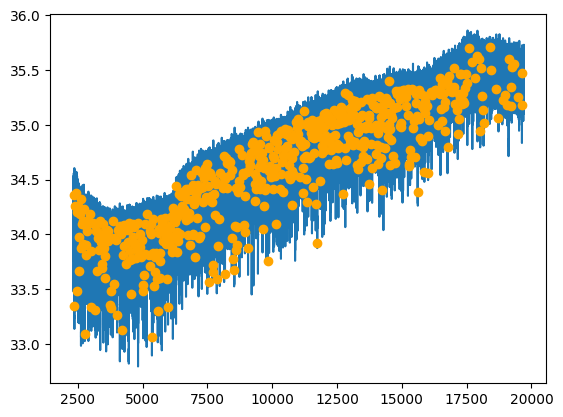

In [105]:
# CALCULATE MOVING MEAN DERIVATIVE
movmean = uniform_filter1d(data["SHEAR STRESS"], mov_mean_window, mode="nearest")
movmean_deriv = FinDiff(0, 1/sampling_freq, 1)(movmean)

# IDENTIFY EVENTS
peaks, _ = find_peaks(-movmean_deriv, height=event_thresh_derivval, distance=event_thresh_derivdist)

# ALT EVENT PICKER
# peaks = (data["SHEAR DETRENDED"]<0) & (data["SHEAR DETRENDED"].shift(-50)<0) & (data.shift(1)["SHEAR DETRENDED"]>0) & (data.shift(50)["SHEAR DETRENDED"]>0) & (data["TIME"] > 3790)
# peaks = np.arange(0, len(data), 1)[peaks]
# diff = np.empty(len(peaks))
# diff[0] = np.inf
# diff[1:] = np.diff(peaks)
# peaks = peaks[diff > 100]

plt.plot(data["TIME"], data["SHEAR STRESS"], zorder=1)
plt.scatter(data["TIME"][peaks], data["SHEAR STRESS"][peaks], color="orange", zorder=2)

In [106]:
###   THE LOOP   ###
####################

events_list=[]
for i, peak in enumerate(peaks):
    if (peak-event_halfwidth)<0 or (peak+event_halfwidth) > len(data):
        continue
    datum = data[peak-event_halfwidth:peak+event_halfwidth].copy()
    
    max_stress = np.nanmax(datum["SHEAR STRESS"])
    min_stress = np.nanmin(datum["SHEAR STRESS"])
    stress_drop = max_stress-min_stress
    if i > 0:
        time_to_previous = (peak - peaks[i-1])/sampling_freq
    else:
        time_to_previous = np.nan
    if (i+1) < len(peaks):
        time_to_next = (peaks[i+1]-peak)/sampling_freq
    else:
        time_to_next = np.nan
    event_roi = None
    peak_time = data["TIME"][peak]
    if "ROIs" in exp_meta:
        for i, ROI in enumerate(exp_meta["ROIs"]):
            if peak_time >= ROI[0] and peak_time < ROI[1]:
                event_roi = i
    events_list.append({
        "peak_loc": peak,
        "peak_time": peak_time,
        "max_stress": max_stress,
        "min_stress": min_stress,
        "stress_drop": stress_drop,
        "time_to_previous": time_to_previous,
        "time_to_next": time_to_next,
        "ROI": event_roi
    })

df = pd.DataFrame(events_list)

## Plots

In [107]:
from itertools import cycle
from decimal import Decimal
def roi_spans(ax):
    face_cycler = cycle([(.9,.9,.9), (.95,.95,.95)])
    clr_cycler = cycle([(.5,.5,.5), (.65, .65, .65)])
    for ROI in exp_meta["ROIs"]:
        ax.axvspan(ROI[0], ROI[1], zorder=0, facecolor=next(face_cycler))
        ax.annotate(ROI[2], ((ROI[1]+ROI[0])/2, .9), xycoords=("data", "figure fraction"), ha="center", weight="bold", fontsize="8", color=next(clr_cycler))

def mean_std_cv(series, label, breakpoint=True):
    mean = str(round(series.mean(), 2))
    std = str(round(series.std(), 2))
    cv = "{:.2E}".format(Decimal(series.std()/series.mean()))
    return_string = r"$"+label+"="+mean+r"\pm"+std+("$\n$" if breakpoint else r"\,")+"CV="+cv+r"$" # 
    return return_string

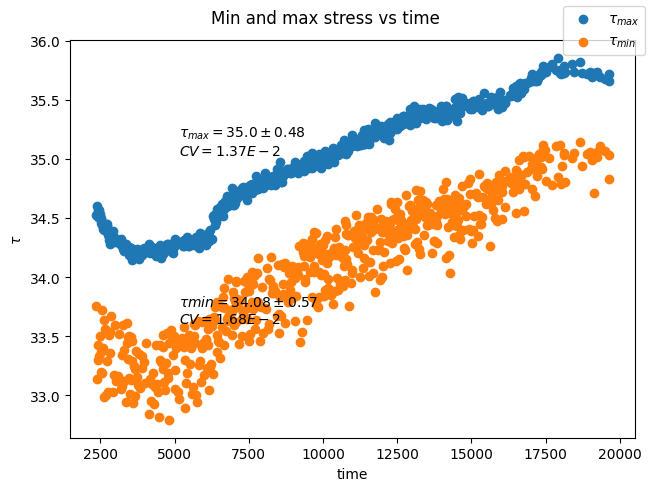

In [108]:
###   MIN AND MAX STRESS VS TIME   ###
###############################
fig, ax = plt.subplots(layout="constrained")
fig.suptitle("Min and max stress vs time")
ax.scatter(df["peak_time"], df["max_stress"], label=r"$\tau_{max}$", zorder=2)
ax.scatter(df["peak_time"], df["min_stress"], label=r"$\tau_{min}$", zorder=3)
ax.set_ylabel(r"$\tau$")
ax.set_xlabel("time")
fig.legend()
# ax.plot(data["TIME"], data["SHEAR STRESS"], color=(.92,.92,.92), zorder=-1, linewidth="1")
# ax.set_xlim(3270, 4360)
# ax.set_ylim(9.22, 9.85)
if "ROIs" in exp_meta:
    roi_spans(ax)
    clr_cycler = cycle([(.4,.4,.4), (.55, .55, .55)])
    for i, ROI in enumerate(exp_meta["ROIs"]):
        clr = next(clr_cycler)
        events = df[df["ROI"] == i]
        annot_str = mean_std_cv(events["max_stress"], r"\tau_{max}") + "\n" + mean_std_cv(events["min_stress"], r"\tau_{min}") + "\n" + mean_std_cv(events["stress_drop"], r"\Delta\tau")
        ax.annotate(annot_str, ((ROI[1]+ROI[0])/2, .2), xycoords=("data", "figure fraction"), ha="center", fontsize="8", color=clr)
else:
    # annot_str =  + "\n" + mean_std_cv(df["min_stress"], r"\tau_{min}") + "\n" + mean_std_cv(df["stress_drop"], r"\Delta\tau")
    ax.annotate(mean_std_cv(df["max_stress"], r"\tau_{max}"), (.28, .7), xycoords="figure fraction", fontsize="10")
    # ax.annotate(mean_std_cv(df["stress_drop"], r"\Delta\tau"), (.6, .48), xycoords="figure fraction", fontsize="10")
    ax.annotate(mean_std_cv(df["min_stress"], r"\tau{min}"), (.28, .35), xycoords="figure fraction", fontsize="10")

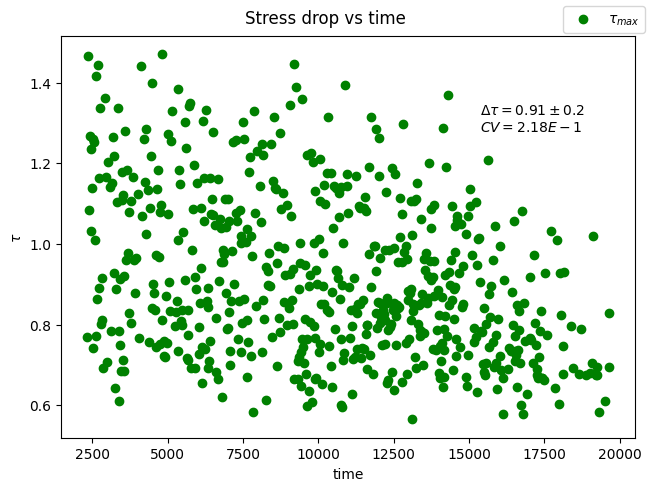

In [114]:
###   STRESS DROP VS TIME   ###
###############################
fig, ax = plt.subplots(layout="constrained")
fig.suptitle("Stress drop vs time")
ax.scatter(df["peak_time"], df["stress_drop"], label=r"$\tau_{max}$", color="g")
ax.set_ylabel(r"$\tau$")
ax.set_xlabel("time")
fig.legend()
# plot.watermark(ax, data)
# ax.set_ylim(0, 0.52)
if "ROIs" in exp_meta:
    roi_spans(ax)
    clr_cycler = cycle([(.4,.4,.4), (.55, .55, .55)])
    for i, ROI in enumerate(exp_meta["ROIs"]):
        clr = next(clr_cycler)
        events = df[df["ROI"] == i]
        annot_str = mean_std_cv(events["max_stress"], r"\tau_{max}") + "\n" + mean_std_cv(events["min_stress"], r"\tau_{min}") + "\n" + mean_std_cv(events["stress_drop"], r"\Delta\tau")
        # ax.annotate(annot_str, ((ROI[1]+ROI[0])/2, .2), xycoords=("data", "figure fraction"), ha="center", fontsize="8", color=clr)
else:
    # ax.annotate(mean_std_cv(df["max_stress"], r"\tau_{max}"), (.28, .7), xycoords="figure fraction", fontsize="10")
    ax.annotate(mean_std_cv(df["stress_drop"], r"\Delta\tau"), (.75, .75), xycoords="figure fraction", fontsize="10")
    # ax.annotate(mean_std_cv(df["min_stress"], r"\tau{min}"), (.28, .35), xycoords="figure fraction", fontsize="10")

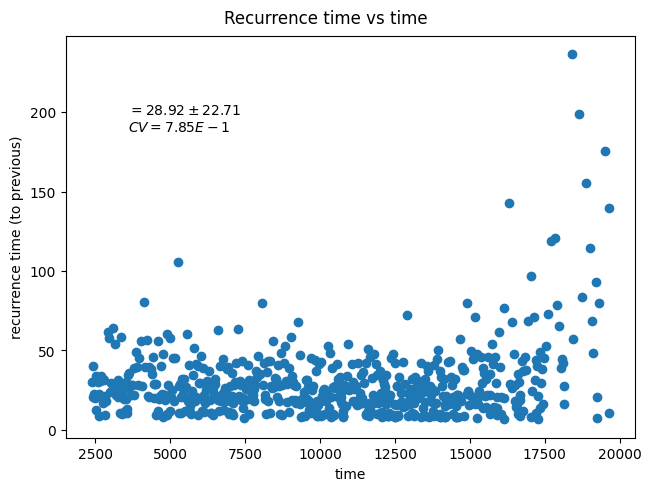

In [110]:
###   RECURRENCE TIME VS TIME   ###
###################################
fig, ax = plt.subplots(layout="constrained")
fig.suptitle("Recurrence time vs time")
ax.scatter(df["peak_time"], df["time_to_previous"])
ax.set_ylabel("recurrence time (to previous)")
ax.set_xlabel("time")
# plot.watermark(ax, data, color=(.9,.9,.9))
# ax.set_xlim(3270, 4360)
if "ROIs" in exp_meta:
    roi_spans(ax)
    clr_cycler = cycle([(.4,.4,.4), (.55, .55, .55)])
    for i, ROI in enumerate(exp_meta["ROIs"]):
        clr = next(clr_cycler)
        events = df[df["ROI"] == i]
        ax.annotate(mean_std_cv(events["time_to_previous"], "t"), ((ROI[1]+ROI[0])/2, .23), xycoords=("data", "figure fraction"), ha="center", fontsize="8", color=clr)
else:
    ax.annotate(mean_std_cv(df["time_to_previous"], ""), (.2, .75), xycoords="figure fraction")

Text(0.5, 0, 'Time to previous')

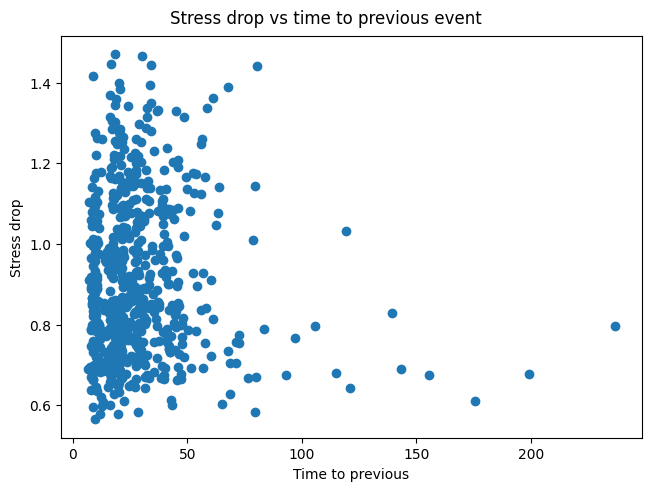

In [111]:
###   STRESS DROP VS TIME TO PREVIOUS   ###
###########################################
fig, ax = plt.subplots(layout="constrained")
fig.suptitle("Stress drop vs time to previous event")
ax.scatter(df["time_to_previous"], df["stress_drop"])
ax.set_ylabel("Stress drop")
ax.set_xlabel("Time to previous")

Text(0.5, 0.5, '$\\Delta \\tau=0.91\\pm0.2$ \n $CV=2.18E-1$')

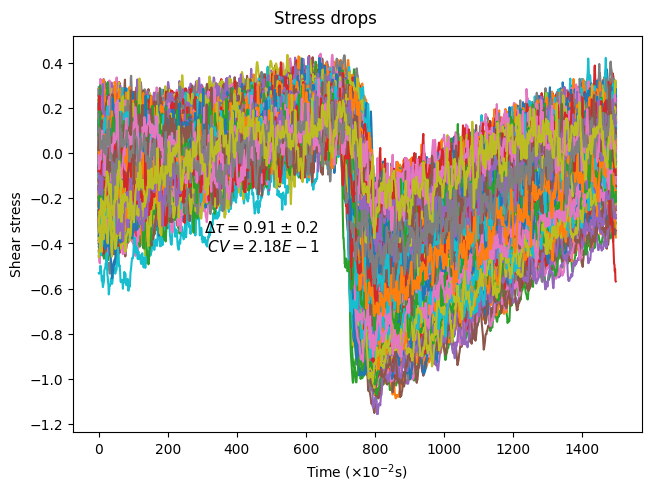

In [112]:
###   SHAPE OF SLIP EVENTS   ###
################################
from decimal import Decimal
fig, ax = plt.subplots(layout="constrained")
for i, row in df.iterrows():
    if (row["peak_loc"]-3*event_halfwidth)<0 or (row["peak_loc"]+3*event_halfwidth) > len(data):
        print("continuing")
        continue
    datum = data[int(row["peak_loc"])-3*event_halfwidth:int(row["peak_loc"])+3*event_halfwidth]
    y_shift = data["SHEAR STRESS"].max() - row["max_stress"]
    ax.plot(range(6*event_halfwidth), datum["SHEAR DETRENDED"])

fig.suptitle("Stress drops")
ax.set_ylabel("Shear stress")
ax.set_xlabel("Time ($\\times 10^{-2}$s)")

# tau_max_mean = str(round(df["max_stress"].mean(), 2))
# tau_max_std = str(round(df["max_stress"].std(), 2))
# tau_max_cv = "{:.2E}".format(Decimal(df["max_stress"].std()/df["max_stress"].mean()))
# ax.annotate(r"$\tau_{max}="+tau_max_mean+r"\pm"+tau_max_std+"$ \n $CV="+tau_max_cv+r"$", (.6, .8), xycoords="figure fraction", fontsize="11", ha="left")

# tau_min_mean = str(round(df["min_stress"].mean(), 2))
# tau_min_std = str(round(df["min_stress"].std(), 2))
# tau_min_cv = "{:.2E}".format(Decimal(df["min_stress"].std()/df["min_stress"].mean()))
# ax.annotate(r"$\tau_{min}="+tau_min_mean+r"\pm"+tau_min_std+"$ \n $CV="+tau_min_cv+r"$", (.5, .22), xycoords="figure fraction", fontsize="11", ha="right")

tau_drop_mean = str(round(df["stress_drop"].mean(), 2))
tau_drop_std = str(round(df["stress_drop"].std(), 2))
tau_drop_cv = "{:.2E}".format(Decimal(df["stress_drop"].std()/df["stress_drop"].mean()))
ax.annotate(r"$\Delta \tau="+tau_drop_mean+r"\pm"+tau_drop_std+"$ \n $CV="+tau_drop_cv+r"$", (.5, .5), xycoords="figure fraction", fontsize="11", ha="right")

In [ ]:
###   SHAPE OF SLIP EVENTS   ###
################################
from decimal import Decimal
fig, ax = plt.subplots(layout="constrained")
for i, ROI in enumerate(exp_meta["ROIs"]):
    events = df[df["ROI"] == i]
    mat = np.empty((len(events), 6*event_halfwidth)) * np.nan
    for i, row in df.iterrows():
        if (peak-3*event_halfwidth)<0 or (peak+3*event_halfwidth) > len(data):
            continue
        mat[i,:] = data[int(row["peak_loc"])-3*event_halfwidth:int(row["peak_loc"])+3*event_halfwidth]["SHEAR STRESS"]
        # y_shift = data["SHEAR STRESS"].max() - row["max_stress"]
    mea = np.mean(mat, axis=0)
    ax.plot(range(6*event_halfwidth), mea)




# for i, row in df.iterrows():
#     if (peak-3*event_halfwidth)<0 or (peak+3*event_halfwidth) > len(data):
#         continue
#     datum = data[int(row["peak_loc"])-3*event_halfwidth:int(row["peak_loc"])+3*event_halfwidth]
#     # y_shift = data["SHEAR STRESS"].max() - row["max_stress"]
#     ax.plot(range(6*event_halfwidth), datum["SHEAR STRESS"])

# fig.suptitle("Stress drops")
# ax.set_ylabel("Shear stress")
# ax.set_xlabel("Time ($\\times 10^{-2}$s)")

# tau_max_mean = str(round(df["max_stress"].mean(), 2))
# tau_max_std = str(round(df["max_stress"].std(), 2))
# tau_max_cv = "{:.2E}".format(Decimal(df["max_stress"].std()/df["max_stress"].mean()))
# ax.annotate(r"$\tau_{max}="+tau_max_mean+r"\pm"+tau_max_std+"$ \n $CV="+tau_max_cv+r"$", (.6, .8), xycoords="figure fraction", fontsize="11", ha="left")

# tau_min_mean = str(round(df["min_stress"].mean(), 2))
# tau_min_std = str(round(df["min_stress"].std(), 2))
# tau_min_cv = "{:.2E}".format(Decimal(df["min_stress"].std()/df["min_stress"].mean()))
# ax.annotate(r"$\tau_{min}="+tau_min_mean+r"\pm"+tau_min_std+"$ \n $CV="+tau_min_cv+r"$", (.5, .22), xycoords="figure fraction", fontsize="11", ha="right")

# tau_drop_mean = str(round(df["stress_drop"].mean(), 2))
# tau_drop_std = str(round(df["stress_drop"].std(), 2))
# tau_drop_cv = "{:.2E}".format(Decimal(df["stress_drop"].std()/df["stress_drop"].mean()))
# ax.annotate(r"$\Delta \tau="+tau_drop_mean+r"\pm"+tau_drop_std+"$ \n $CV="+tau_drop_cv+r"$", (.5, .5), xycoords="figure fraction", fontsize="11", ha="right")

In [ ]:
###   TIME TO NEXT VS TIME TO PREVIOUS   ###
############################################
fig, ax = plt.subplots(layout="constrained")
ax.scatter(df["time_to_previous"], df["time_to_next"], alpha=0.7)
fig.suptitle("Time to previous vs time to next")
ax.set_ylabel("Time to next")
ax.set_xlabel("Time to previous")